<a href="https://colab.research.google.com/github/DerekZ66/ALY6110/blob/main/ALY6110_Final_Team1_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Running Hive on Pyspark in Colab**

Prepare PySpark Cluster

In [ ]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

#Run a local spark session to test your installation:

In [ ]:
# install findspark using pip
import findspark
findspark.init()
from pyspark.sql import SparkSession
#spark = SparkSession.builder.master("local[*]").getOrCreate()
spark = SparkSession.builder.master("local[*]").enableHiveSupport().getOrCreate()


# Upload Data to Working Directory

In [ ]:
from google.colab import files
files.upload()

Saving housing.csv to housing.csv


{'housing.csv': b'longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity\n-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY\n-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY\n-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY\n-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY\n-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY\n-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY\n-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY\n-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.12,241400.0,NEAR BAY\n-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY\n-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY\n-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY\n-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY\n-

In [ ]:
import pylab as pl
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col,isnan, when, count
import pyspark.sql.functions as F
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import when
from pyspark.ml.feature import StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Load Data to Spark Cluster

In [ ]:
df = spark.read.csv('housing.csv',inferSchema=True, header =True)

# Data processing and EDA

In [ ]:
# EDA
df.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

In [ ]:
# EDA
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [ ]:
# EDA
df.describe().show()

+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|summary|          longitude|         latitude|housing_median_age|       total_rooms|    total_bedrooms|        population|       households|     median_income|median_house_value|ocean_proximity|
+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|  count|              20640|            20640|             20640|             20640|             20433|             20640|            20640|             20640|             20640|          20640|
|   mean|-119.56970445736148| 35.6318614341087|28.639486434108527|2635.7630813953488| 537.8705525375618|1425.4767441860465|499.5396802325581|3.8706710029070246|206855.81690891474|           null|
| stddev|  2.0035317

In [ ]:
# show null values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|           207|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



In [ ]:
# multiple median_income by 10000 to standarize the monetory amount
df = df.withColumn("median_income", df["median_income"] * 10000)

In [ ]:
# fill null values with mean
total_bedrooms_mean = df.select(F.mean('total_bedrooms')).collect()[0][0]
df.fillna(value = total_bedrooms_mean)
df=df.na.fill(value=total_bedrooms_mean, subset=["total_bedrooms"])

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|             0|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



In [ ]:
# factorize ocean_proximity
ocean_proximity_factor = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_type")
df = ocean_proximity_factor.fit(df).transform(df)
df.show()
df.select("ocean_proximity", "ocean_proximity_type").distinct().show()

+---------+--------+------------------+-----------+--------------+----------+----------+------------------+------------------+---------------+--------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|     median_income|median_house_value|ocean_proximity|ocean_proximity_type|
+---------+--------+------------------+-----------+--------------+----------+----------+------------------+------------------+---------------+--------------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|           83252.0|          452600.0|       NEAR BAY|                 3.0|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0| 83013.99999999999|          358500.0|       NEAR BAY|                 3.0|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|           72574.0|          352100.0|       NEAR BAY|                 3.0|
|  -122.25|   37

In [ ]:
df = df.drop("ocean_proximity")
df = df.withColumnRenamed("ocean_proximity_type", "ocean_proximity")
df.show()

+---------+--------+------------------+-----------+--------------+----------+----------+------------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|     median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+------------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|           83252.0|          452600.0|            3.0|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0| 83013.99999999999|          358500.0|            3.0|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|           72574.0|          352100.0|            3.0|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0| 56430.99999999999|          341300.0|            3.0|

# Clustering

In [ ]:
# clustering
input_features = [col for col in df.columns if col not in ['longitude', 'latitude']]
assembler = VectorAssembler(inputCols = input_features, outputCol='features')
assembled_df = assembler.transform(df)
assembled_df.show()

+---------+--------+------------------+-----------+--------------+----------+----------+------------------+------------------+---------------+--------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|     median_income|median_house_value|ocean_proximity|            features|
+---------+--------+------------------+-----------+--------------+----------+----------+------------------+------------------+---------------+--------------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|           83252.0|          452600.0|            3.0|[41.0,880.0,129.0...|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0| 83013.99999999999|          358500.0|            3.0|[21.0,7099.0,1106...|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|           72574.0|          352100.0|            3.0|[52.0,1467.0,190....|
|  -122.25|   37

In [ ]:
# perform elbow method to find optimal number of clusters

# Calculate cost and plot
cost = np.zeros(10)

for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(100).setFeaturesCol('features')
    model = kmeans.fit(assembled_df)
    cost[k] = model.summary.trainingCost


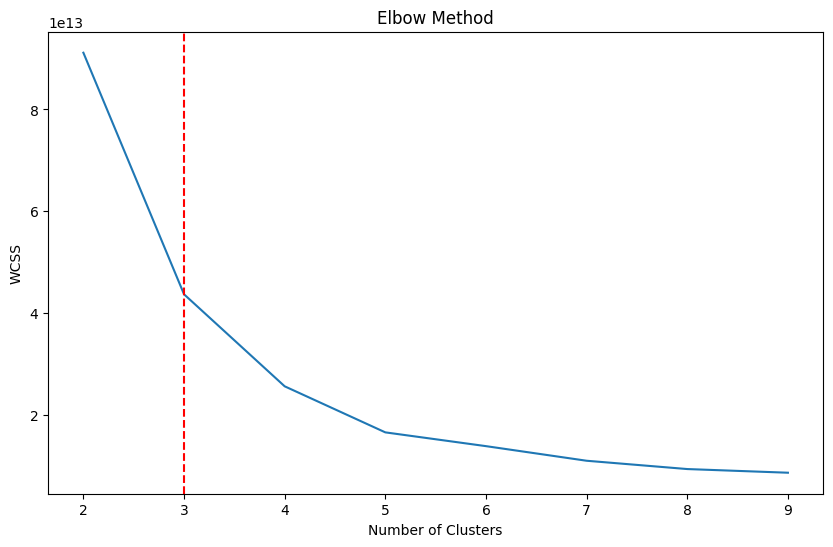

In [ ]:
# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = list(range(2,10))
df_cost.insert(0, 'cluster', new_col)

pl.figure(figsize=(10,6))
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('WCSS')
pl.title('Elbow Method')
pl.axvline(x=3, color='red', linestyle='--')

In [ ]:
#based on elbow - 3 clusters
kmeans_3 = KMeans(featuresCol="features",k=3)
model_3 = kmeans_3.fit(assembled_df)
model_3

KMeansModel: uid=KMeans_e5f1b0314165, k=3, distanceMeasure=euclidean, numFeatures=8

In [ ]:
#show counts based on pred
model_3.transform(assembled_df).groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 3118|
|         2| 7343|
|         0|10179|
+----------+-----+



In [ ]:
predictions =model_3.transform(assembled_df)
predictions.show()

+---------+--------+------------------+-----------+--------------+----------+----------+------------------+------------------+---------------+--------------------+----------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|     median_income|median_house_value|ocean_proximity|            features|prediction|
+---------+--------+------------------+-----------+--------------+----------+----------+------------------+------------------+---------------+--------------------+----------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|           83252.0|          452600.0|            3.0|[41.0,880.0,129.0...|         1|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0| 83013.99999999999|          358500.0|            3.0|[21.0,7099.0,1106...|         1|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|           72574.0|          352100.0

In [ ]:
housingclustering = predictions.drop(col("features"))
housingclustering.show(10)

+---------+--------+------------------+-----------+--------------+----------+----------+-----------------+------------------+---------------+----------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|    median_income|median_house_value|ocean_proximity|prediction|
+---------+--------+------------------+-----------+--------------+----------+----------+-----------------+------------------+---------------+----------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|          83252.0|          452600.0|            3.0|         1|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|83013.99999999999|          358500.0|            3.0|         1|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|          72574.0|          352100.0|            3.0|         1|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     

In [ ]:
# Define the columns for which you want to calculate statistics
columns_to_drop = ["longitude", "latitude", "ocean_proximity","features"]
housingclustering_stat = predictions.drop(*columns_to_drop)
housingclustering_stat.show()

+------------------+-----------+--------------+----------+----------+------------------+------------------+----------+
|housing_median_age|total_rooms|total_bedrooms|population|households|     median_income|median_house_value|prediction|
+------------------+-----------+--------------+----------+----------+------------------+------------------+----------+
|              41.0|      880.0|         129.0|     322.0|     126.0|           83252.0|          452600.0|         1|
|              21.0|     7099.0|        1106.0|    2401.0|    1138.0| 83013.99999999999|          358500.0|         1|
|              52.0|     1467.0|         190.0|     496.0|     177.0|           72574.0|          352100.0|         1|
|              52.0|     1274.0|         235.0|     558.0|     219.0| 56430.99999999999|          341300.0|         1|
|              52.0|     1627.0|         280.0|     565.0|     259.0|           38462.0|          342200.0|         1|
|              52.0|      919.0|         213.0| 

In [ ]:
# calculate the statistics based on pred
cluster_stats = predictions.groupBy("prediction").agg(
    F.count("*").alias("count"),

    #F.mean("housing_median_age").alias("mean_housing_median_age"),
    #F.stddev_pop("housing_median_age").alias("stddev_housing_median_age"),
    #F.min("housing_median_age").alias("min_housing_median_age"),
    #F.max("housing_median_age").alias("max_housing_median_age"),

    #F.mean("total_rooms").alias("mean_total_rooms"),
    #F.stddev_pop("total_rooms").alias("stddev_total_rooms"),
    #F.min("total_rooms").alias("min_total_rooms"),
    #F.max("total_rooms").alias("max_total_rooms"),

    #F.mean("total_bedrooms").alias("mean_total_bedrooms"),
    #F.stddev_pop("total_bedrooms").alias("stddev_total_bedrooms"),
    #F.min("total_bedrooms").alias("min_total_bedrooms"),
    #F.max("total_bedrooms").alias("max_total_bedrooms"),

    #F.mean("population").alias("mean_population"),
    #F.stddev_pop("population").alias("stddev_population"),
    #F.min("population").alias("min_population"),
    #F.max("population").alias("max_population"),

    #F.mean("households").alias("mean_households"),
    #F.stddev_pop("households").alias("stddev_households"),
    #F.min("households").alias("min_households"),
    #F.max("households").alias("max_households"),

    F.mean("median_income").alias("mean_median_income"),
    F.stddev_pop("median_income").alias("stddev_median_income"),
    #F.min("median_income").alias("min_median_income"),
    #F.max("median_income").alias("max_median_income"),

    F.mean("median_house_value").alias("mean_median_house_value"),
    F.stddev_pop("median_house_value").alias("stddev_median_house_value"),
    #F.min("median_house_value").alias("min_median_house_value"),
    #F.max("median_house_value").alias("max_median_house_value")
)

cluster_stats.show()

+----------+-----+------------------+--------------------+-----------------------+-------------------------+
|prediction|count|mean_median_income|stddev_median_income|mean_median_house_value|stddev_median_house_value|
+----------+-----+------------------+--------------------+-----------------------+-------------------------+
|         1| 3118| 62657.86016677357|  26139.880936510253|     424504.57504810777|        63539.83644021976|
|         2| 7343| 42543.98406645785|  13222.832325439093|      238067.2068636797|        41460.80393281568|
|         0|10179|28601.907063562237|  10389.612871631336|      117670.8218882012|        36822.59046884975|
+----------+-----+------------------+--------------------+-----------------------+-------------------------+



In [ ]:
vis_df = predictions.toPandas()
# build figure with 3D numeric dimensions and categorical isPlanet and prediction dimensions
fig = px.scatter_3d(vis_df, x='median_house_value', y='median_income', z='households', color='prediction', template='ggplot2')
fig.update_traces(marker_size = 1)
fig.update_layout(width=800, height=600)
fig.show()

#cluster 2: high house value, high income
#cluster 1: middle house value, middle income
#cluster 0：low house value, low income

In [ ]:
# build figure with 3D numeric dimensions and categorical isPlanet and prediction dimensions
fig = px.scatter_3d(vis_df, x='median_house_value', y='median_income', z='housing_median_age', color='prediction', template='ggplot2')
fig.update_traces(marker_size = 1)
fig.update_layout(width=800, height=600)
fig.show()


In [ ]:
# build figure with 3D numeric dimensions and categorical isPlanet and prediction dimensions
fig = px.scatter_3d(vis_df, x='median_house_value', y='median_income', z='total_rooms', color='prediction', template='ggplot2')
fig.update_traces(marker_size = 1)
fig.update_layout(width=800, height=600)
fig.show()


In [ ]:
fig = px.scatter_3d(vis_df, z='median_house_value', x='longitude', y='latitude', color='prediction', template='ggplot2')
fig.update_traces(marker_size = 2)
fig.update_layout(width=800, height=600)
fig.show()

# Regression

In [ ]:
df.show()

+---------+--------+------------------+-----------+--------------+----------+----------+------------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|     median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+------------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|           83252.0|          452600.0|            3.0|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0| 83013.99999999999|          358500.0|            3.0|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|           72574.0|          352100.0|            3.0|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0| 56430.99999999999|          341300.0|            3.0|

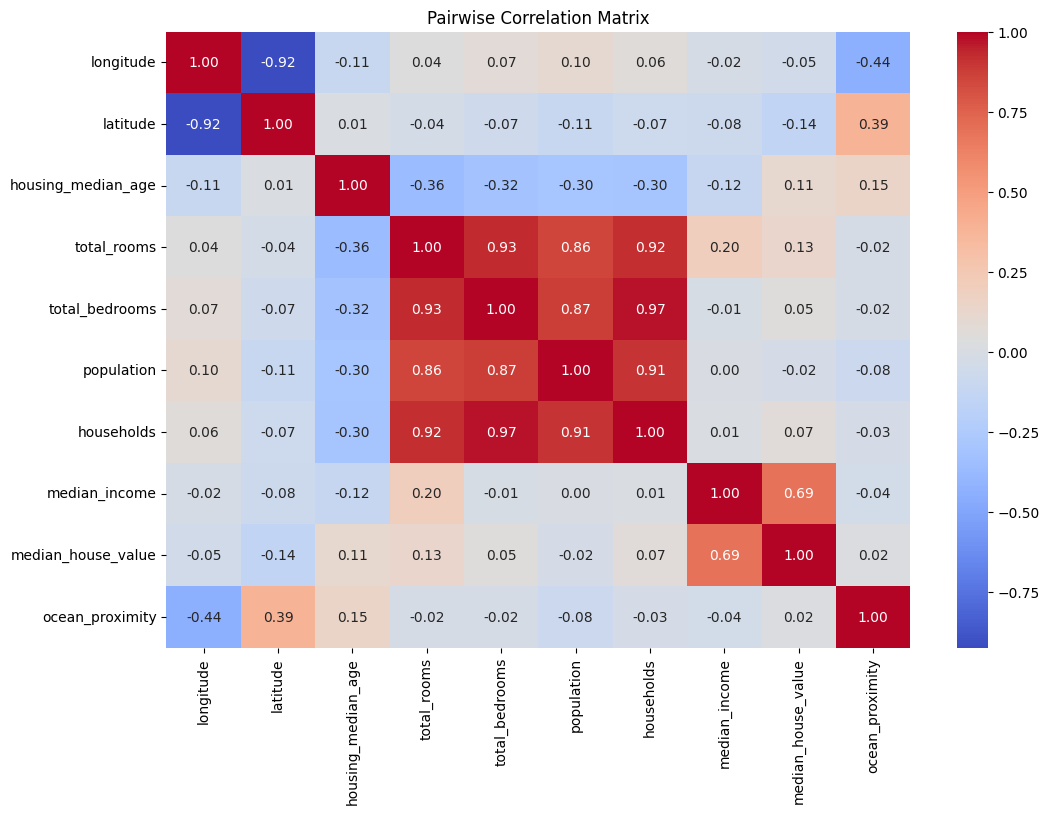

In [ ]:
# Calculate the pairwise correlation matrix
correlation_matrix = df.toPandas().corr()

# Plot the correlation heatmap with correlation valuss as annotations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size': 10})
plt.title('Pairwise Correlation Matrix')
plt.show()

In [ ]:
only_features = ['households','population','total_bedrooms','median_income','total_rooms','housing_median_age','ocean_proximity']

# vectorize the features
assembler = VectorAssembler(inputCols=only_features, outputCol="features")
assembled_df = assembler.transform(df)

# feature scaling
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)

# inspect the result
scaled_df.select("features", "features_scaled").show(5, truncate=False)

+--------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------+
|features                                                |features_scaled                                                                                                                        |
+--------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------+
|[126.0,322.0,129.0,83252.0,880.0,41.0,3.0]              |[0.3295584480852433,0.2843362208866199,0.30768013087921575,4.382095394195218,0.40337085073160667,3.2577023016083064,2.9864139366491074]|
|[1138.0,2401.0,1106.0,83013.99999999999,7099.0,21.0,3.0]|[2.9764882057222772,2.1201592122632746,2.6379397267628883,4.369567902917909,3.2540109878905406,1.668579227653035,2.9864139366491074]   |
|[177.0,496.0,190.0,72574

In [ ]:
import pprint
# split the data into train and test sets
train_data, test_data = scaled_df.randomSplit([.8,.2], seed=1000)

# Create a Linear Regression Estimator
lr = LinearRegression(featuresCol="features_scaled", labelCol="median_house_value")
lr_model = lr.fit(train_data)

coefficients = lr_model.coefficients

intercept = lr_model.intercept

# Print the coefficients with the name of the features
print("Model - Multivariable Linear Regression")
print("Coefficients:")
pprint.pprint(dict(zip(only_features, lr_model.coefficients)))
print("Intercept: %f" %intercept)


# Summarize the model over the training set and print out some metrics
trainingSummary = lr_model.summary
print("Performance of the model on the training data:")
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f \n" % trainingSummary.r2)


# Make predictions on the test data
predictions = lr_model.evaluate(test_data)


rmse_evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2")
print("Performance of the model on the testing data:")
print("RMSE: %f" % rmse_evaluator.evaluate(predictions.predictions))
print("r2: %f \n" % r2_evaluator.evaluate(predictions.predictions))

Model - Multivariable Linear Regression
Coefficients:
{'households': 54786.826476274065,
 'housing_median_age': 23814.94396949791,
 'median_income': 89656.7104719745,
 'ocean_proximity': 969.7888388648264,
 'population': -39896.40992842517,
 'total_bedrooms': 33077.530250055024,
 'total_rooms': -40377.37705277622}
Intercept: -45781.422451
Performance of the model on the training data:
RMSE: 76407.089254
r2: 0.557090 

Performance of the model on the testing data:
RMSE: 74641.780094
r2: 0.597943 



# Lasso Regression

In [ ]:
# perform lasso regression
lasso_regression = LinearRegression(featuresCol='features_scaled', labelCol="median_house_value",  elasticNetParam=1, maxIter=10)
linearModel = lasso_regression.fit(train_data)

# Print the coefficients with the name of the features
print("Model - LASSO Regression")
print("Coefficients:")
pprint.pprint(dict(zip(only_features, linearModel.coefficients)))
print("Intercept: %s \n" % str(linearModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = linearModel.summary
print("Performance of the model on the training data:")
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f \n" % trainingSummary.r2)


# Make predictions on the test data
ls_predictions = linearModel.transform(test_data)

# Summarize the model over the testing set and print out some metrics
rmse_evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2")
print("Performance of the model on the testing data:")
print("RMSE: %f" % rmse_evaluator.evaluate(ls_predictions))
print("r2: %f \n" % r2_evaluator.evaluate(ls_predictions))

Model - LASSO Regression
Coefficients:
{'households': 54786.826476274065,
 'housing_median_age': 23814.94396949791,
 'median_income': 89656.7104719745,
 'ocean_proximity': 969.7888388648264,
 'population': -39896.40992842517,
 'total_bedrooms': 33077.530250055024,
 'total_rooms': -40377.37705277622}
Intercept: -45781.42245115758 

Performance of the model on the training data:
RMSE: 76407.089254
r2: 0.557090 

Performance of the model on the testing data:
RMSE: 74641.780094
r2: 0.597943 



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Define the hyperparameter grid
param_grid = ParamGridBuilder().addGrid(lasso_regression.regParam, [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 10]).build()

# Create the cross-validator
evaluator = RegressionEvaluator( labelCol= "median_house_value", metricName="rmse")
cross_validator = CrossValidator(estimator=lasso_regression, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=10)

# Train the model with the best hyperparameters
cv_model = cross_validator.fit(train_data)
lasso_model = cv_model.bestModel
print("Best lambda: ", lasso_model.getRegParam())

Best lambda:  0.0


In [ ]:
lasso_regression_best = LinearRegression(labelCol='median_house_value', featuresCol='features_scaled', elasticNetParam=1, regParam=0, maxIter=10)
linearModel = lasso_regression_best.fit(train_data)

# Print the coefficients with the name of the features
print("Model - LASSO Regression")
print("Coefficients:")
pprint.pprint(dict(zip(only_features, linearModel.coefficients)))
print("Intercept: %s \n" % str(linearModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = linearModel.summary
print("Performance of the model on the training data:")
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f \n" % trainingSummary.r2)


# Make predictions on the test data
predictions = linearModel.transform(test_data)

# Summarize the model over the testing set and print out some metrics
rmse_evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2")
print("Performance of the model on the testing data:")
print("RMSE: %f" % rmse_evaluator.evaluate(predictions))
print("r2: %f \n" % r2_evaluator.evaluate(predictions))

Model - LASSO Regression
Coefficients:
{'households': 54786.826476274065,
 'housing_median_age': 23814.94396949791,
 'median_income': 89656.7104719745,
 'ocean_proximity': 969.7888388648264,
 'population': -39896.40992842517,
 'total_bedrooms': 33077.530250055024,
 'total_rooms': -40377.37705277622}
Intercept: -45781.42245115758 

Performance of the model on the training data:
RMSE: 76407.089254
r2: 0.557090 

Performance of the model on the testing data:
RMSE: 74641.780094
r2: 0.597943 



# Random Forest

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
# Create a RandomForestRegressor model
rf = RandomForestRegressor(labelCol="median_house_value", numTrees=100, maxDepth=4)

# Split the data into training and testing sets
train_data, test_data = assembled_df.randomSplit([0.8, 0.2],seed=1000)

# Fit the Random Forest model to the training data
rf_model = rf.fit(train_data)

# Make predictions on the test dataset
rf_predictions = rf_model.transform(test_data)

# Evaluate the Random Forest model using appropriate metrics (e.g., RMSE or MAE)
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(rf_predictions)

evaluator_mae = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(rf_predictions)


print("Random Forest RMSE:", rmse)
print("Random Forest MAE:", mae)

Random Forest RMSE: 72126.00421625953
Random Forest MAE: 54463.612450566216


In [ ]:
evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2")
r_squared = evaluator.evaluate(rf_predictions)

print("Random Forest R-squared (R2):", r_squared)

Random Forest R-squared (R2): 0.6245888164881717


In [ ]:
feature_importances = rf_model.featureImportances

In [ ]:
# input_features = assembled_df.getInputCols()
only_features

['households',
 'population',
 'total_bedrooms',
 'median_income',
 'total_rooms',
 'housing_median_age',
 'ocean_proximity']

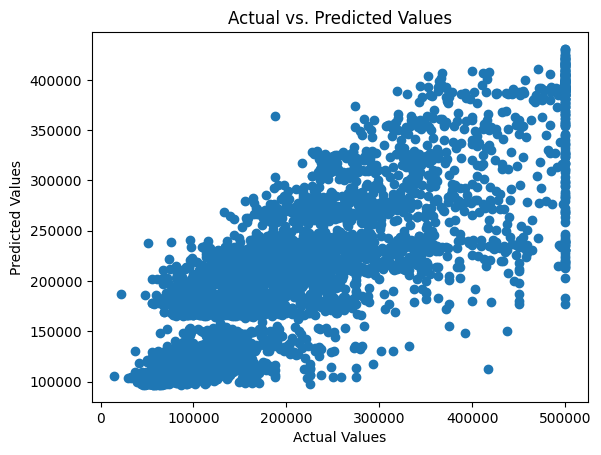

In [ ]:
# Assuming you have a Pandas DataFrame with actual and predicted values
actual = test_data.select("median_house_value").toPandas()
predicted = rf_predictions.select("prediction").toPandas()

plt.scatter(actual, predicted)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

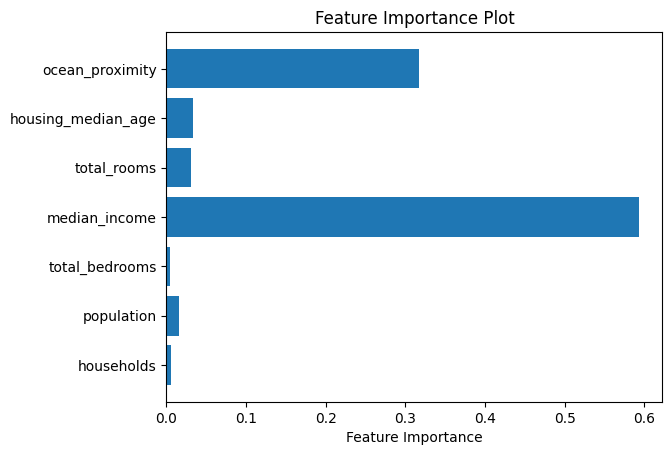

In [ ]:
importances = feature_importances.toArray()
indices = range(len(importances))

plt.barh(indices, importances, align="center")
plt.yticks(indices, only_features)
plt.xlabel("Feature Importance")
plt.title("Feature Importance Plot")
plt.show()

In [ ]:
importances

array([0.00526843, 0.01530001, 0.00468172, 0.59294778, 0.03115904,
       0.03387897, 0.31676403])

#Support Vector Regression

In [ ]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

# Create a Vector Assembler for input features
assembler = VectorAssembler(inputCols=["features_scaled"], outputCol="input_features")
assembled_df = assembler.transform(scaled_df)

# Split the data into a training set and a testing set
train_data, test_data = assembled_df.randomSplit([0.7, 0.3], seed=111)

# Create a GBT Regressor model
gbt = GBTRegressor(featuresCol="input_features", labelCol="median_house_value", maxIter=10, maxDepth=5, seed=111)

# Fit the GBT model to the training data
gbt_model = gbt.fit(train_data)

# Make predictions on the training data using the GBT model
train_predictions = gbt_model.transform(train_data)

# Evaluate the model's performance on the training data with RMSE and R-squared
rmse_evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2")

rmse_train = rmse_evaluator.evaluate(train_predictions)
r2_train = r2_evaluator.evaluate(train_predictions)

# Print the model's coefficients and performance metrics for training data
print("Model - Gradient Boosted Trees (GBT) Regressor - Training Data")
print("Performance of the model on the training data:")
print("RMSE: %f" % rmse_train)
print("R-squared (r2): %f" % r2_train)

# Make predictions on the test data using the GBT model
test_predictions = gbt_model.transform(test_data)

# Evaluate the model's performance on the test data with RMSE and R-squared
rmse_test = rmse_evaluator.evaluate(test_predictions)
r2_test = r2_evaluator.evaluate(test_predictions)

# Print the model's coefficients and performance metrics for test data
print("Model - Gradient Boosted Trees (GBT) Regressor - Testing Data")
print("Performance of the model on the testing data:")
print("RMSE: %f" % rmse_test)
print("R-squared (r2): %f" % r2_test)

Model - Gradient Boosted Trees (GBT) Regressor - Training Data
Performance of the model on the training data:
RMSE: 64184.851933
R-squared (r2): 0.687341
Model - Gradient Boosted Trees (GBT) Regressor - Testing Data
Performance of the model on the testing data:
RMSE: 67563.446770
R-squared (r2): 0.665300


In [ ]:
#spark.stop()